# Comparing AUC-ROC and AUC-PRC: Replicating and Extending Saito and Rehmsmeier #
    - Matt Robinson, matthew67robinson@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def plot_roc_curves(y_scores, y_test, title='ROC curves'):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))
    for i in range(len(y_scores)):
        # Compute ROC curve and area the curve
        scores = y_scores[i]
        classes = y_test[i]
        fpr, tpr, thresholds = roc_curve(classes, scores)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='Run %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    #print('mean auc', np.mean(aucs))
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean AUC-ROC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1), shadow=True, ncol=1)
    plt.show()

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_scores, y_test, imbalance=None,
                   title='PR Curves', text_loc=[0.1,0.7]):

    precisions = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))

    for i in range(len(y_scores)):
        scores = y_scores[i]
        classes = y_test[i]
        precision, recall, thresholds = precision_recall_curve(classes, scores)
        avg_precision = average_precision_score(classes, scores)
        #aucs.append(avg_precision)
        aucs.append(auc(recall, precision))
        plt.step(recall, precision, color='b', alpha=0.2,
             where='post',label='Run %d (AUC = %0.2f)' % (i, avg_precision))

        i += 1

#     print('MEAN PR-AUC:', np.mean(aucs))
#     print('STD PR-AUC:', np.std(aucs))
    std_auc = np.std(aucs)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.text(text_loc[0], text_loc[1],
             f'MEAN AUC-PRC: {round(np.mean(aucs),3)} \n STD AUC-PRC: {round(np.std(aucs),3)}')
    if imbalance is not None:
        plt.plot([0, 1], [imbalance, imbalance], linestyle='--', lw=2, color='r',
                 label='Chance', alpha=.8)
    plt.title(title, fontsize=16)
    plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
    plt.show()

In [37]:
def enrichment_plots(y_scores, y_test):
    for i in range(len(y_scores)):
        scores = y_scores[i]
        classes = y_test[i]
        
        total_actives = sum(classes)
        total_cmpds = len(classes)
        sorted_cmpds = np.array(
            [x for _, x in sorted(zip(scores,classes),
                                  key=lambda pair: pair[0],
                                  reverse=True)])
        
        enrichment_dict = {}
        num_actives = 0
        num_cmpds = 0
        for j in range(len(sorted_cmpds)):
            num_cmpds += 1
            if sorted_cmpds[j] == 1:
                num_actives += 1
            
            enrichment = (num_actives/num_cmpds)/(total_actives/total_cmpds)
            pct = 100*(num_cmpds/total_cmpds)
            enrichment_dict[pct] = enrichment
            
        plt.plot(list(enrichment_dict.keys()), list(enrichment_dict.values()))
                 
    plt.xlabel('percentage', fontsize=14)
    plt.ylabel('enrichment', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Enrichment Plots', fontsize=16)
    plt.xlim(0,20)

# Our Example: #

Text(0.5,1,'Theoretical Classifier Discrimination ')

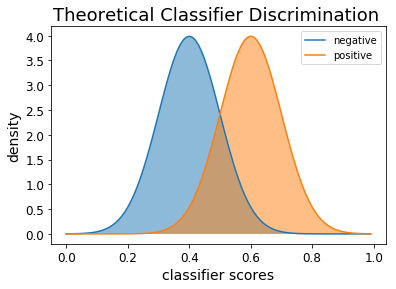

In [38]:
x_axis = np.arange(0, 1, 0.01)

plt.plot(x_axis, scipy.stats.norm.pdf(x_axis,0.4,0.1), label='negative')
plt.fill_between(x_axis, scipy.stats.norm.pdf(x_axis,0.4,0.1), alpha=0.5)

plt.plot(x_axis, scipy.stats.norm.pdf(x_axis,0.6,0.1), label='positive')
plt.fill_between(x_axis, scipy.stats.norm.pdf(x_axis,0.6,0.1), alpha=0.5)

plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('classifier scores', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.title('Theoretical Classifier Discrimination ', fontsize=18)

NUMBER OF INACTIVES:  10000
NUMBER OF ACTIVES:  100

Random Classifier ROC-AUC: 0.5
Random Classifier PR-AUC:  0.009900990099009901


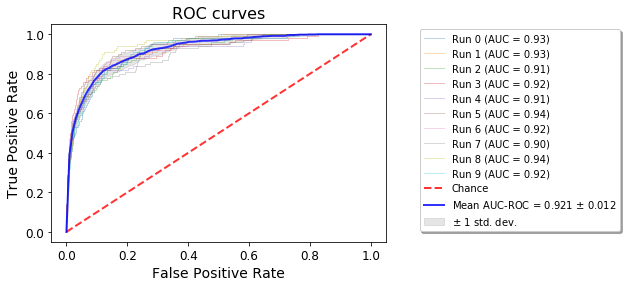

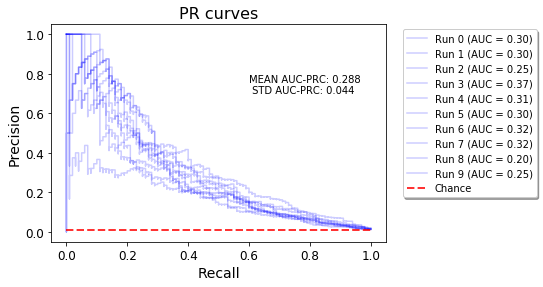

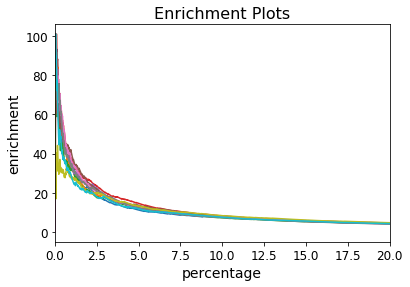

In [41]:
neg_size = 10000
pos_size = 100

imbalance = pos_size/(pos_size+neg_size)
print('NUMBER OF INACTIVES: ',neg_size)
print('NUMBER OF ACTIVES: ', pos_size)
print('')
print('Random Classifier ROC-AUC: 0.5')
print('Random Classifier PR-AUC: ', imbalance)

all_scores = []
all_classes = []
for i in range(10):
    
    neg_scores = np.random.normal(0.4,0.1,size=neg_size)
    pos_scores = np.random.normal(0.6,0.1,size=pos_size)

    scores = np.concatenate((neg_scores, pos_scores))
    classes = np.concatenate((np.zeros(neg_size), np.ones(pos_size)))
    
    all_scores.append(scores)
    all_classes.append(classes)
    
plot_roc_curves(all_scores, all_classes, title=f'ROC curves')
plot_pr_curves(all_scores, all_classes, imbalance,
               title=f'PR curves', text_loc=[0.6,0.7])

enrichment_plots(all_scores, all_classes)

Text(0.5,1,'Early Performance Classifier Discrimination')

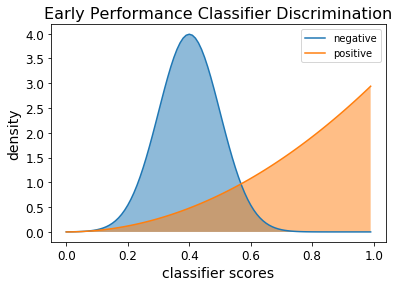

In [44]:
x_axis = np.arange(0, 1, 0.01)

plt.plot(x_axis, scipy.stats.norm.pdf(x_axis,0.4,0.1), label='negative')
plt.fill_between(x_axis, scipy.stats.norm.pdf(x_axis,0.4,0.1), alpha=0.5)

plt.plot(x_axis, scipy.stats.beta.pdf(x_axis,3,1), label='positive')
plt.fill_between(x_axis, scipy.stats.beta.pdf(x_axis,3,1), alpha=0.5)

plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('classifier scores', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.title('Early Performance Classifier Discrimination', fontsize=16)

NUMBER OF INACTIVES:  10000
NUMBER OF ACTIVES:  100

Random Classifier ROC-AUC: 0.5
Random Classifier PR-AUC:  0.009900990099009901


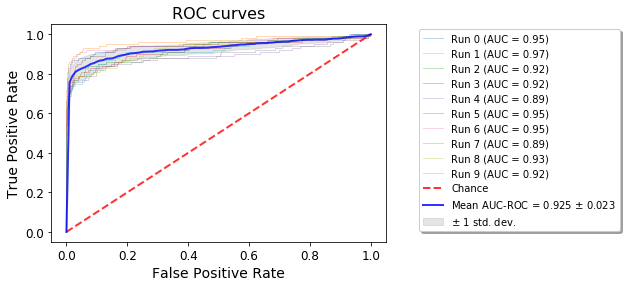

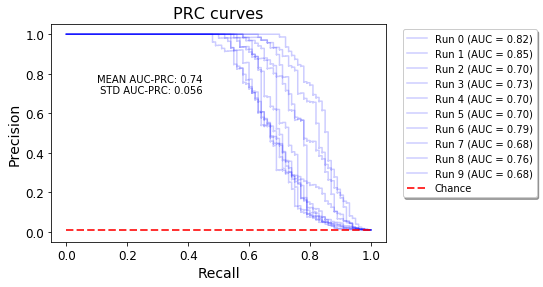

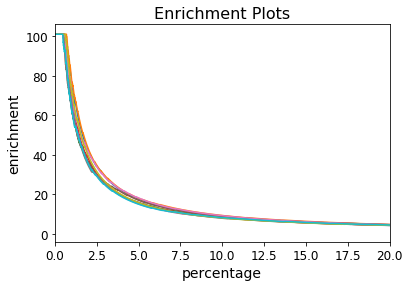

In [45]:
neg_size = 10000
pos_size = 100

imbalance = pos_size/(pos_size+neg_size)
print('NUMBER OF INACTIVES: ',neg_size)
print('NUMBER OF ACTIVES: ', pos_size)
print('')
print('Random Classifier ROC-AUC: 0.5')
print('Random Classifier PR-AUC: ', imbalance)

all_scores = []
all_classes = []
for i in range(10):
    
    neg_scores = np.random.normal(0.4,0.1,size=neg_size)
    pos_scores = np.random.beta(3,1,size=pos_size)

    scores = np.concatenate((neg_scores, pos_scores))
    classes = np.concatenate((np.zeros(neg_size), np.ones(pos_size)))
    
    all_scores.append(scores)
    all_classes.append(classes)
    
plot_roc_curves(all_scores, all_classes, title=f'ROC curves')
plot_pr_curves(all_scores, all_classes, imbalance, title=f'PRC curves')

enrichment_plots(all_scores, all_classes)

# Their Example #

### First: Poor early retreival ###

Text(0.5,1,'Poor Early Retrieval Classifier Discrimination')

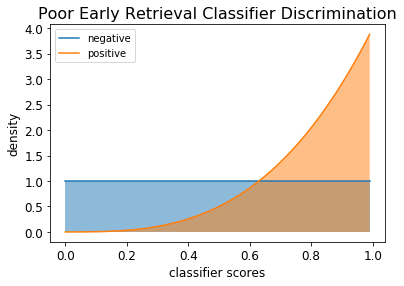

In [46]:
# poor early retreival

x_axis = np.arange(0, 1, 0.01)

plt.plot(x_axis, scipy.stats.beta.pdf(x_axis,1,1), label='negative')
plt.fill_between(x_axis, scipy.stats.beta.pdf(x_axis,1,1), alpha=0.5)

plt.plot(x_axis, scipy.stats.beta.pdf(x_axis,4,1), label='positive')
plt.fill_between(x_axis, scipy.stats.beta.pdf(x_axis,4,1), alpha=0.5)

plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('classifier scores', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.title('Poor Early Retrieval Classifier Discrimination', fontsize=16)

NUMBER OF INACTIVES:  10000
NUMBER OF ACTIVES:  100

Random Classifier ROC-AUC: 0.5
Random Classifier PR-AUC:  0.009900990099009901


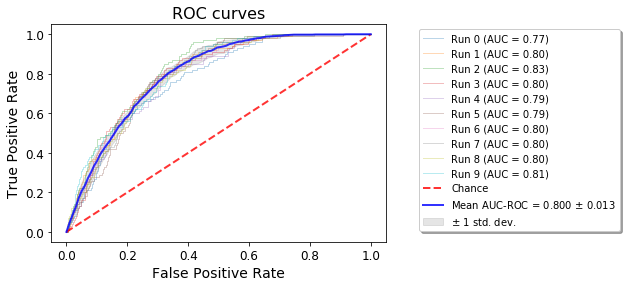

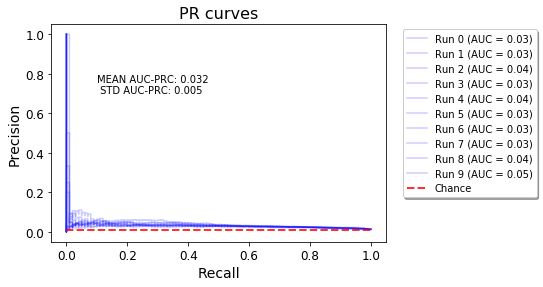

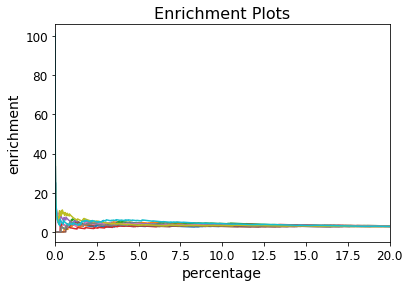

In [47]:
neg_size = 10000
pos_size = 100

imbalance = pos_size/(pos_size+neg_size)
print('NUMBER OF INACTIVES: ',neg_size)
print('NUMBER OF ACTIVES: ', pos_size)
print('')
print('Random Classifier ROC-AUC: 0.5')
print('Random Classifier PR-AUC: ', imbalance)

all_scores = []
all_classes = []
for i in range(10):
    
    neg_scores = np.random.beta(1,1,size=neg_size)
    pos_scores = np.random.beta(4,1,size=pos_size)

    scores = np.concatenate((neg_scores, pos_scores))
    classes = np.concatenate((np.zeros(neg_size), np.ones(pos_size)))
    
    all_scores.append(scores)
    all_classes.append(classes)
    
plot_roc_curves(all_scores, all_classes, title=f'ROC curves')
plot_pr_curves(all_scores, all_classes, imbalance, title=f'PR curves')

enrichment_plots(all_scores, all_classes)

### Second: Good early retreival ###

Text(0.5,1,'Good Early Retrieval Classifier Discrimination')

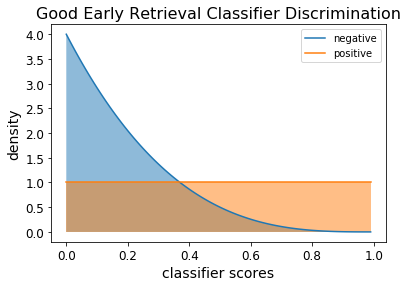

In [48]:
# good early retreival

x_axis = np.arange(0, 1, 0.01)

plt.plot(x_axis, scipy.stats.beta.pdf(x_axis,1,4), label='negative')
plt.fill_between(x_axis, scipy.stats.beta.pdf(x_axis,1,4), alpha=0.5)

plt.plot(x_axis, scipy.stats.beta.pdf(x_axis,1,1), label='positive')
plt.fill_between(x_axis, scipy.stats.beta.pdf(x_axis,1,1), alpha=0.5)

plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('classifier scores',fontsize=14)
plt.ylabel('density',fontsize=14)
plt.title('Good Early Retrieval Classifier Discrimination', fontsize=16)

NUMBER OF INACTIVES:  10000
NUMBER OF ACTIVES:  100

Random Classifier ROC-AUC: 0.5
Random Classifier PR-AUC:  0.009900990099009901


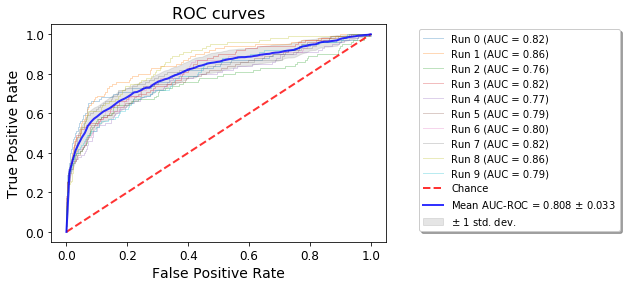

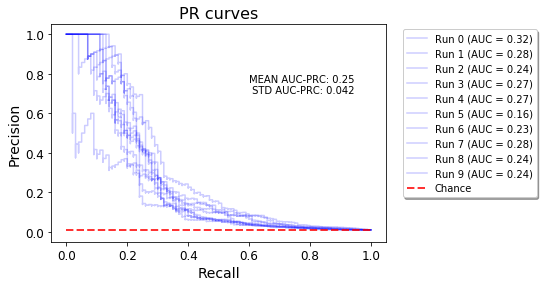

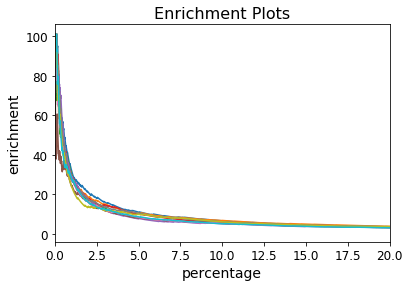

In [51]:
neg_size = 10000
pos_size = 100

imbalance = pos_size/(pos_size+neg_size)
print('NUMBER OF INACTIVES: ',neg_size)
print('NUMBER OF ACTIVES: ', pos_size)
print('')
print('Random Classifier ROC-AUC: 0.5')
print('Random Classifier PR-AUC: ', imbalance)

all_scores = []
all_classes = []
for i in range(10):
    
    neg_scores = np.random.beta(1,4,size=neg_size)
    pos_scores = np.random.beta(1,1,size=pos_size)

    scores = np.concatenate((neg_scores, pos_scores))
    classes = np.concatenate((np.zeros(neg_size), np.ones(pos_size)))
    
    all_scores.append(scores)
    all_classes.append(classes)
    
plot_roc_curves(all_scores, all_classes, title=f'ROC curves')
plot_pr_curves(all_scores, all_classes, imbalance, title=f'PR curves', text_loc=[0.6,0.7])

enrichment_plots(all_scores, all_classes)

# ROC and PRC varying with class imbalance #

Note that the AUC-ROC is the same in both of these cases below, but the AUC-PRC changes quite drastically with class imbalance

Text(0.5,1,'Theoretical Classifier Discrimination')

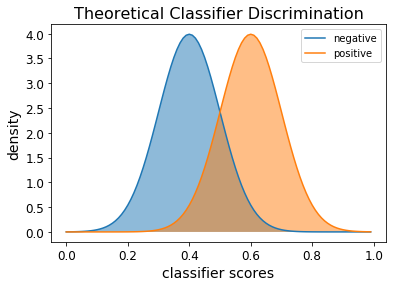

In [52]:
x_axis = np.arange(0, 1, 0.01)

plt.plot(x_axis, scipy.stats.norm.pdf(x_axis,0.4,0.1), label='negative')
plt.fill_between(x_axis, scipy.stats.norm.pdf(x_axis,0.4,0.1), alpha=0.5)

plt.plot(x_axis, scipy.stats.norm.pdf(x_axis,0.6,0.1), label='positive')
plt.fill_between(x_axis, scipy.stats.norm.pdf(x_axis,0.6,0.1), alpha=0.5)

plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('classifier scores', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.title('Theoretical Classifier Discrimination', fontsize=16)

First, Class imbalance of 0.5 :

NUMBER OF INACTIVES:  10000
NUMBER OF ACTIVES:  10000

Random Classifier ROC-AUC: 0.5
Random Classifier PR-AUC:  0.5


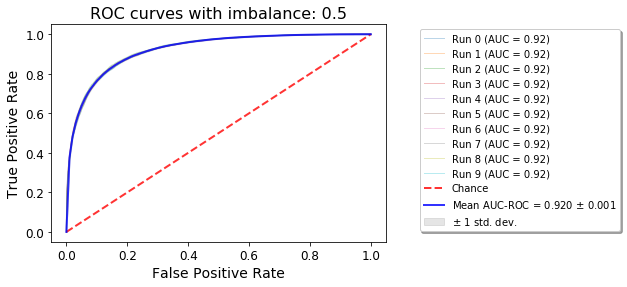

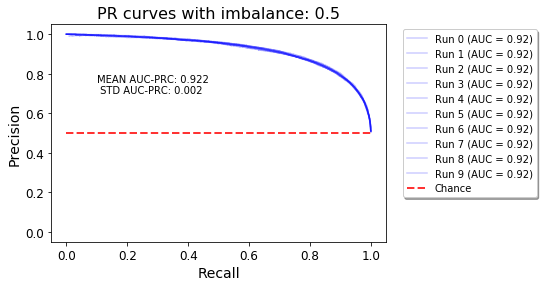

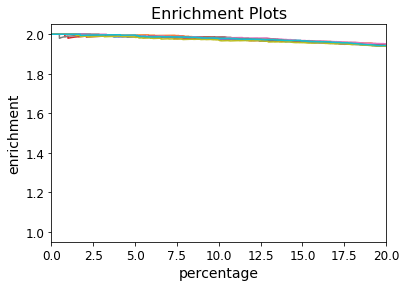

In [53]:
# HIT RATE OF 50%

neg_size = 10000
pos_size = 10000

imbalance = pos_size/(pos_size+neg_size)
print('NUMBER OF INACTIVES: ', neg_size)
print('NUMBER OF ACTIVES: ', pos_size)
print('')
print('Random Classifier ROC-AUC: 0.5')
print('Random Classifier PR-AUC: ', imbalance)

all_scores = []
all_classes = []
for i in range(10):
    
    neg_scores = np.random.normal(0.4,0.1,size=neg_size)
    pos_scores = np.random.normal(0.6,0.1,size=pos_size)

    scores = np.concatenate((neg_scores, pos_scores))
    classes = np.concatenate((np.zeros(neg_size), np.ones(pos_size)))
    
    all_scores.append(scores)
    all_classes.append(classes)
    
plot_roc_curves(all_scores, all_classes, title=f'ROC curves with imbalance: {imbalance}')
plot_pr_curves(all_scores, all_classes, imbalance, title=f'PR curves with imbalance: {imbalance}')

enrichment_plots(all_scores, all_classes)

Second, Class imbalance of 0.01 :

NUMBER OF INACTIVES:  10000
NUMBER OF ACTIVES:  100

Random Classifier ROC-AUC: 0.5
Random Classifier PR-AUC:  0.009900990099009901


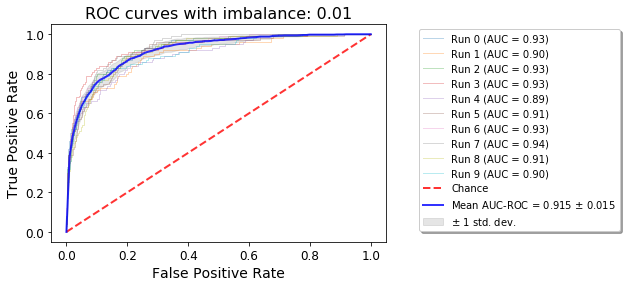

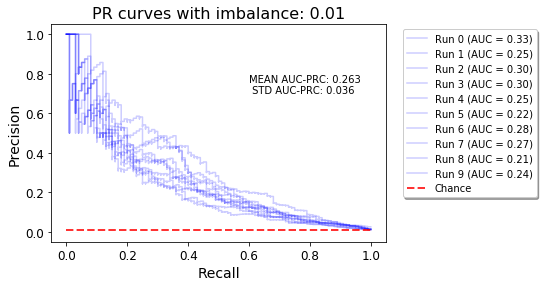

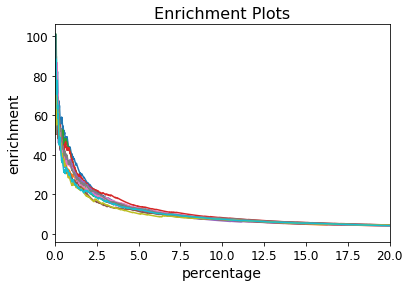

In [57]:
### HIT RATE OF 1% ###

neg_size = 10000
pos_size = 100

imbalance = pos_size/(pos_size+neg_size)
print('NUMBER OF INACTIVES: ',neg_size)
print('NUMBER OF ACTIVES: ', pos_size)
print('')
print('Random Classifier ROC-AUC: 0.5')
print('Random Classifier PR-AUC: ', imbalance)

all_scores = []
all_classes = []
for i in range(10):
    
    neg_scores = np.random.normal(0.4,0.1,size=neg_size)
    pos_scores = np.random.normal(0.6,0.1,size=pos_size)

    scores = np.concatenate((neg_scores, pos_scores))
    classes = np.concatenate((np.zeros(neg_size), np.ones(pos_size)))
    
    all_scores.append(scores)
    all_classes.append(classes)
    
plot_roc_curves(all_scores, all_classes,
                title=f'ROC curves with imbalance: {round(imbalance,3)}')
plot_pr_curves(all_scores, all_classes, imbalance,
               title=f'PR curves with imbalance: {round(imbalance,3)}',
               text_loc=[0.6, 0.7])

enrichment_plots(all_scores, all_classes)